In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 75%; }
</style>
"""))

In [2]:
%matplotlib inline
import os
import sys
import gc
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
#from src.utilities.transformer import Transformer
from src.learning.training.generator import Generator, GenFiles
from src.learning.models import create_standalone_nvidia_cnn, create_standalone_resnet, create_small_cnn
                                

In [3]:
def plot_stuff(title, plot_elem, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #x = np.arange(0, len(plot_elems[0]['data']), 1)
    
    #for plot_elem in plot_elems:
    #    plt.errorbar(x, plot_elem['data'], yerr=plot_elem['error'], label=plot_elem['label'], alpha=plot_elem['alpha'], fmt='-o', capsize=5)
    
    plt.plot(list(range(1,len(plot_elem['data'])+1)), plot_elem['data'])
    plt.grid(axis='both')
    #plt.legend(loc='best', prop={'size': 15})
    plt.show()
    plt.savefig('./' + title + '.png')
    
def get_model_num(model_path, model_prefix):
    model_files = [fn for fn in os.listdir(model_path) if fn.startswith(model_prefix) and fn.endswith('.h5') and 'dagger_' not in fn]
    # expected format is "model_n1_m1_9.h5"
    existing_nums = [int(fn.split('_')[3].split('.')[0]) for fn in model_files]
    
    if len(existing_nums) == 0:
        return 1
    else:
        latest_num = sorted(existing_nums)[-1]
        return int(latest_num) + 1

In [4]:
config_manager = ConfigurationManager()
config = config_manager.config

memory = (1, 1)
#ARDI' comment -- we just use (1,1) this refers to how many frames are used and sth else, not sure what

model_path = '../'

../config/configuration.yml


In [5]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch>30 and epoch%10==0:
        lr*=0.5
    return lr


# Model experiments
import os

epochs = 50
batch_size = 64
verbose = 1

losses = []
val_losses = []

#in here added option to not shuffle, so last 20% of recording time is used as val set -- in future might want to reduce proportion of val set
generator = Generator(config, memory_tuple= memory, base_path='../', batch_size=batch_size, column_mode='steer', shuffle_data=False) 

frame_shape, numeric_shape, diff_shape = generator.get_shapes()
tqdm.write('Target shape: {}'.format(diff_shape)) #tqdm is some package that allow to track the progress of operations
tqdm.write('Input shapes: {}; {}'.format(frame_shape, numeric_shape))

models = []

#ARDI's comment:  Nividia is the model we want to use (resnet might be good to??)
#models.append((create_standalone_nvidia_cnn(activation='linear', input_shape=(60, 180, 3), output_shape=2), generator.generate))

#"steer and throttle"
#models.append((create_small_cnn(activation='linear', input_shape=(60, 180, 3), output_shape=2), generator.generate))

generator = Generator(config, memory_tuple= memory, base_path='../', batch_size=batch_size, column_mode='all', shuffle_data=False) 
models.append((create_small_cnn(activation='linear', input_shape=(50, 180, 3), output_shape=2), generator.generate))

callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)]

for model, generate_method in tqdm(models):
    result_desc = 'n{}_m{}'.format(*memory)
    tqdm.write(result_desc)

    hist = model.fit(generate_method(data='train'),
                     steps_per_epoch=generator.train_batch_count,
                     validation_data=generate_method(data='test'),
                     validation_steps=generator.test_batch_count,
                     callbacks=callbacks,
                     epochs=epochs, verbose=verbose)

    model_file_prefix = 'model_n{}_m{}'.format(*memory)
    model_file_suffix = '_{}.{}'

    model_number = get_model_num(model_path, model_file_prefix)
    plot_model(model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
    model.save(model_path + model_file_prefix + model_file_suffix.format(model_number, 'h5'))
    
    current_loss = hist.history['loss']
    current_val_loss = hist.history['val_loss'] 
    
    losses.append(current_loss)
    print(val_losses)
    val_losses.append(current_val_loss)
    
    tqdm.write("Loss per epoch: {}".format(current_loss))
    tqdm.write("Validation loss per epoch: {}".format(current_val_loss))
    
    gc.collect()

os.system("printf '\a'")

/home/deepmind/projects/deltax/RCSnail-AI-lite/notebooks [    0     1     2 ... 29762 29763 29764]
Target shape: 1
Input shapes: (50, 180, 3); (2,)
/home/deepmind/projects/deltax/RCSnail-AI-lite/notebooks [    0     1     2 ... 29762 29763 29764]


n1_m1
shuffle called again
Epoch 1/50
440/441 [============================>.] - ETA: 0s - loss: 0.4337shuffle called again
shuffle called again
shuffle called again
441/441 [==============================] - 16s 35ms/step - loss: 0.4336 - val_loss: 0.3481 - lr: 3.0000e-04
Epoch 2/50
441/441 [==============================] - 14s 33ms/step - loss: 0.3556 - val_loss: 0.3059 - lr: 3.0000e-04
Epoch 3/50
441/441 [==============================] - 14s 32ms/step - loss: 0.3164 - val_loss: 0.2750 - lr: 3.0000e-04
Epoch 4/50
441/441 [==============================] - 14s 33ms/step - loss: 0.2895 - val_loss: 0.2537 - lr: 3.0000e-04
Epoch 5/50
441/441 [==============================] - 14s 33ms/step - loss: 0.2712 - val_loss: 0.2389 - lr: 3.0000e-04
Epoch 6/50
441/441 [==============================] - 14s 33ms/step - loss: 0.2594 - val_loss: 0.2306 - lr: 3.0000e-04
Epoch 7/50
441/441 [==============================] - 14s 32ms/step - loss: 0.2487 - val_loss: 0.2181 - lr: 3.0000e-04
Epoch 8/50
4

0

[[0.3480626940727234, 0.3058921694755554, 0.27503272891044617, 0.2537315785884857, 0.23891712725162506, 0.23061083257198334, 0.21807967126369476, 0.2163545787334442, 0.2115020751953125, 0.20389489829540253, 0.20141786336898804, 0.19362835586071014, 0.18850962817668915, 0.18033646047115326, 0.17949609458446503, 0.1845800131559372, 0.17345117032527924, 0.1767086386680603, 0.16730265319347382, 0.1660909652709961, 0.1610269546508789, 0.16783395409584045, 0.16571147739887238, 0.17044763267040253, 0.16666975617408752, 0.1657232940196991, 0.16445542871952057, 0.16446994245052338, 0.15805916488170624, 0.16488948464393616, 0.15889295935630798, 0.16200339794158936, 0.15758614242076874, 0.16499793529510498, 0.1633307933807373, 0.1629069447517395, 0.16228510439395905, 0.1712905615568161, 0.16403724253177643, 0.158238023519516, 0.1573789417743683, 0.16047658026218414, 0.16082683205604553, 0.1563441902399063, 0.1597810983657837, 0.15914411842823029, 0.16081643104553223, 0.15471093356609344, 0.160541

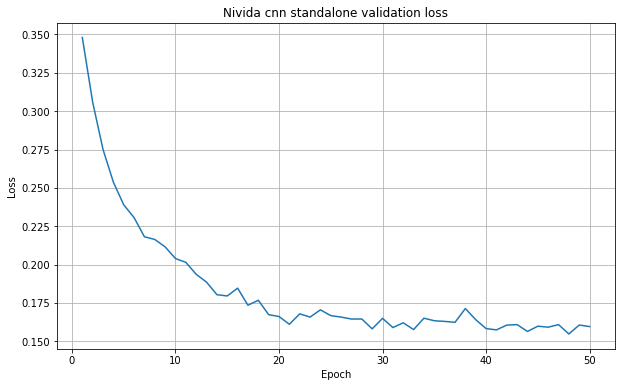

<Figure size 432x288 with 0 Axes>

In [6]:
print(val_losses)
print(hist.history['val_loss'] )
loss_data = []
val_loss_data = []


val_loss_data = {'data': hist.history['val_loss'], 'label': 'Validation loss', 'alpha': 1.0}
plot_stuff('Nivida cnn standalone validation loss', val_loss_data, figsize=(10, 6))


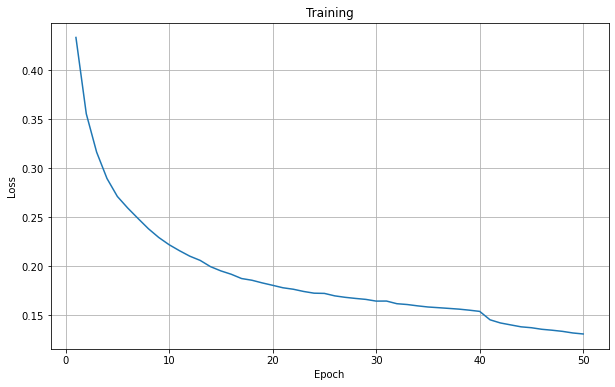

<Figure size 432x288 with 0 Axes>

In [7]:
loss_data = {'data': losses[0], 'label': 'Loss', 'alpha': 1.0}
plot_stuff('Training', loss_data, figsize=(10, 6))

In [12]:
#todo load test set into memeory, evaluate
import keras
model = keras.models.load_model("../masked_test.h5")
import glob

val_data_loc="../n1_m1"
filenames = glob.glob("../n1_m1/*")
print(len(filenames))
nr_of_datapoints = int(len(filenames)/2) #label and image files


MAEs=[]
preds=[]
labels=[]

for batch in range(nr_of_datapoints//32-32,nr_of_datapoints//32): # using the end of file. 32 batches of size batch of 32
    frames=np.zeros((32,50,180,3))
    commands = np.zeros((32,2))
    for i in range(32):
        frames[i,:] = np.load("../n1_m1/frame_"+str(batch*32+i).zfill(7)+".npy")
        commands[i] = np.load("../n1_m1/commands_"+str(batch*32+i).zfill(7)+".npy")
    MAEs.append(model.evaluate(frames,commands, batch_size=32))
    pred = model.predict(frames)
    preds.append(pred)
    labels.append(commands)
    
print(np.mean(MAEs))
#TODO MAE for steer and throttle separately, mased on preds and commands

59530
1/1 [==============================] - 0s 771us/step - loss: 0.2525
0.1532479585148394


0.1532479585148394
(32, 32) (32, 32)


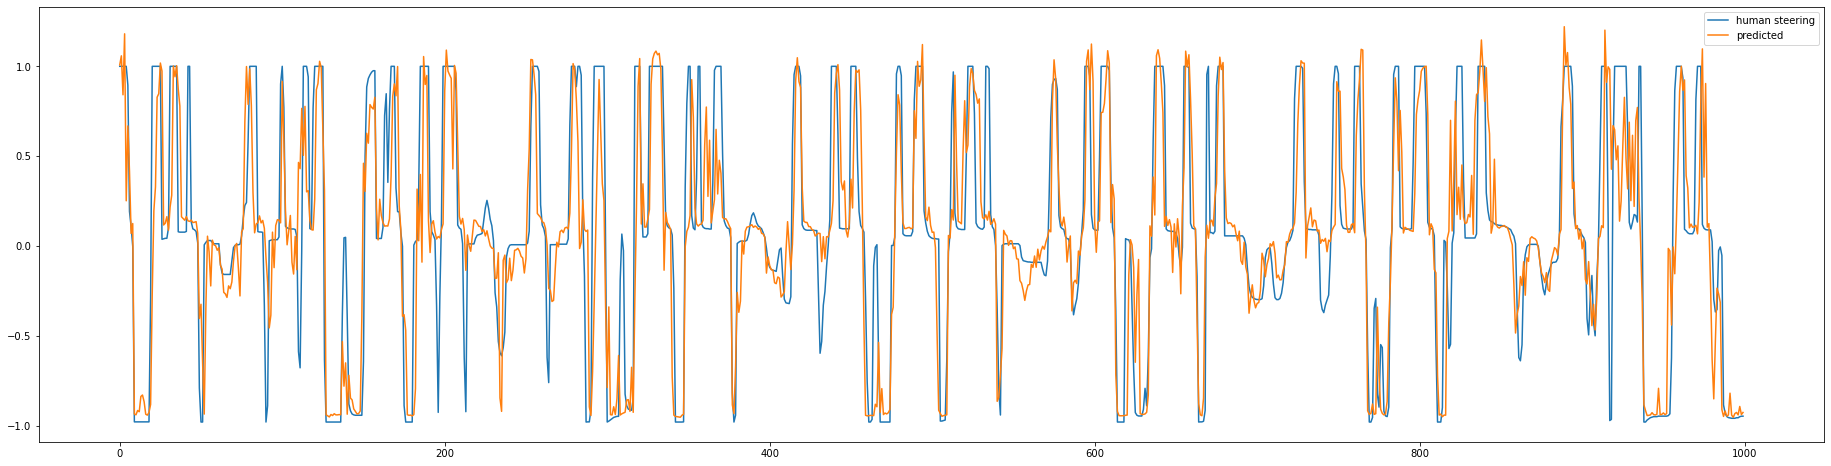

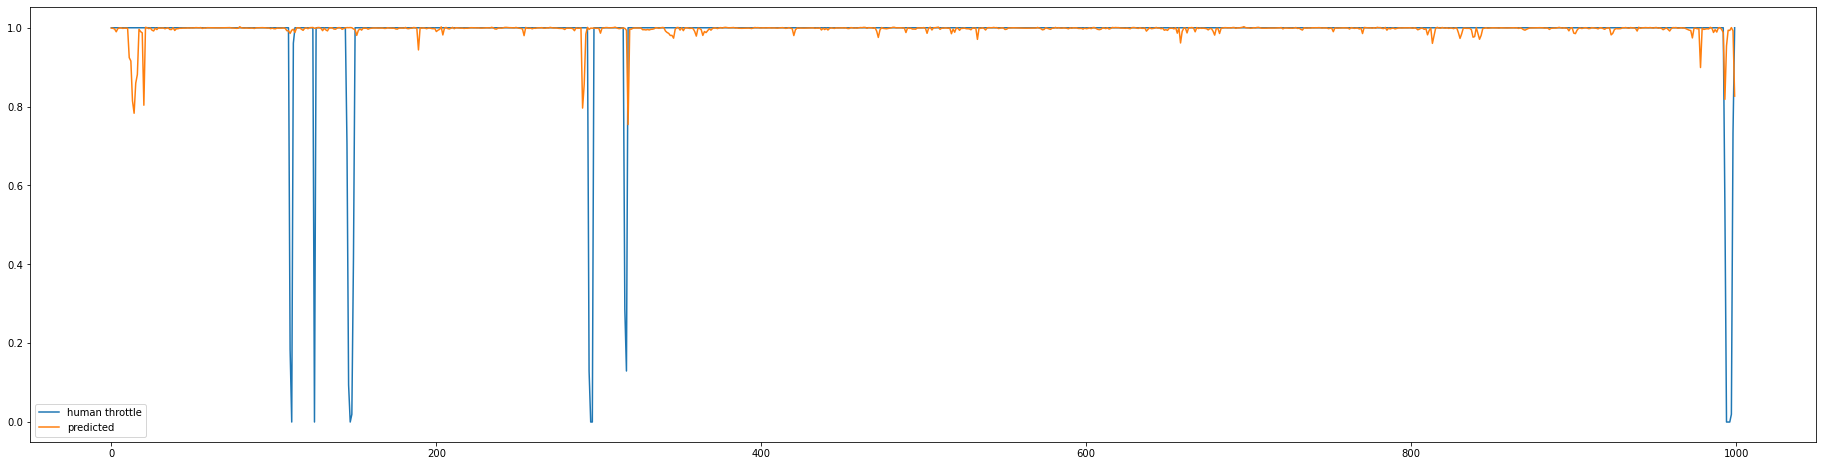

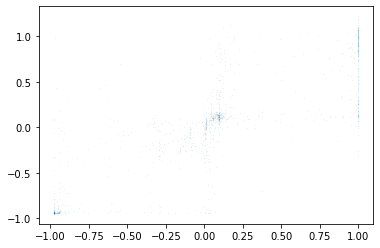

In [11]:
print(np.mean(MAEs))
p_steer=np.array(preds)[:,:,0]
l_steer=np.array(labels)[:,:,0]
p_throttle=np.array(preds)[:,:,1]
l_throttle=np.array(labels)[:,:,1]

print(p_steer.shape,l_steer.shape)
p_steer=p_steer.flatten()
l_steer=l_steer.flatten()
p_throttle=p_throttle.flatten()
l_throttle=l_throttle.flatten()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_steer[:1000],label="human steering")
plt.plot(range(1000),p_steer[:1000],label="predicted")
plt.legend()
plt.show()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_throttle[:1000],label="human throttle")
plt.plot(range(1000),p_throttle[:1000],label="predicted")
plt.legend()
plt.show()



plt.scatter(l_steer,p_steer,s=0.001)